In [2]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import psycopg2
import sys
import datetime as dt
import mp_utils as mp

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

marker = ['v','o','d','^','s','>','+']
ls = ['-','-','-','-','-','s','--','--']

# bigger font !
plt.rcParams.update({'font.size': 22})

%matplotlib inline

from __future__ import print_function

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Plot data from example patient's time-series

In [3]:
df = pd.read_csv('/tmp/mp_data.csv')

In [23]:
# load in this patient's deathtime from the actual experiment
df_offset = pd.read_csv('/tmp/mp_death.csv')

# get censoring information
df_censor = pd.read_csv('/tmp/mp_censor.csv')

# Experiment A: First 24 hours

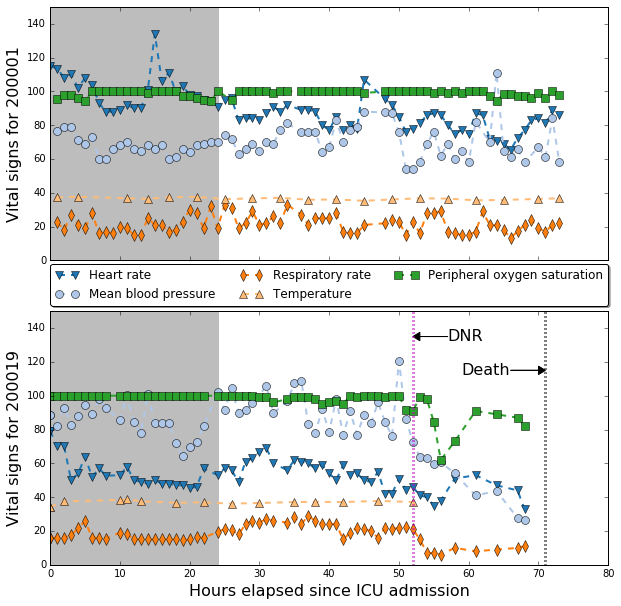

In [59]:
# define the patient
iid  = 200001
iid2 = 200019
T_WINDOW = 24
time_dict = {iid: 24, iid2: 24}

df_pat = df.loc[df['icustay_id']==iid, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid, 'deathtime_hours'].values

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True, figsize=[10,10])

pretty_labels = {'heartrate': 'Heart rate',
                 'meanbp': 'Mean blood pressure',
                 'resprate': 'Respiratory rate',
                 'spo2': 'Peripheral oxygen saturation',
                 'tempc': 'Temperature',
                 'bg_ph': 'pH',
                 'bg_bicarbonate': 'Serum bicarbonate',
                 'hemoglobin': 'Hemoglobin',
                 'potassium': 'Potassium',
                 'inr': 'International normalized ratio',
                 'bg_lactate': 'Lactate',
                 'wbc': 'White blood cell count'}
#var_list = df.columns

# first plot all the vitals in subfigure 1
var_vitals = [u'heartrate', u'meanbp', u'resprate', u'tempc', u'spo2']

i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[0].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)], markersize=8,
                      color=tableau20[i], linewidth=2)
        i+=1
        

axarr[0].set_ylim([0,150])
y_lim = axarr[0].get_ylim()

# add ICU discharge
if dischtime is not np.nan:
    axarr[0].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)

# add a grey patch to represent the window
endtime = time_dict[iid]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[0].add_patch(rect)
# #axarr[0].text(starttime/60.0-4-2,4, 'window',fontsize=16)

axarr[0].set_ylabel('Vital signs for {}'.format(iid),fontsize=16)



# next plot the vitals for the next patient in subfigure 2
df_pat = df.loc[df['icustay_id']==iid2, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid2, 'deathtime_hours'].values


i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed since ICU admission'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[1].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)], markersize=8,
                      color=tableau20[i], linewidth=2)
        i+=1

axarr[1].set_ylim([0,150])
y_lim = axarr[1].get_ylim()

# add ICU discharge
if deathtime is not np.nan:
    axarr[1].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)
    axarr[1].arrow(deathtime-5, 115, 4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(deathtime-12, 112.5, 'Death', fontsize=16)
    
# add DNR
dnrtime = df_censor.loc[df_censor['icustay_id']==iid2, 'censortime_hours'].values
if dnrtime.shape[0]>0:
    axarr[1].plot([dnrtime,dnrtime], y_lim, 'm:', linewidth=3)
    axarr[1].arrow(dnrtime+5, 135, -4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(dnrtime+5, 132.5, 'DNR',fontsize=16)

# add a patch to represent the window
endtime = time_dict[iid2]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[1].add_patch(rect)




axarr[1].set_xlabel(t_unit,fontsize=16)
axarr[1].set_ylabel('Vital signs for {}'.format(iid2),fontsize=16)
axarr[1].legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=3)
plt.show()

# Experiment B: Random time

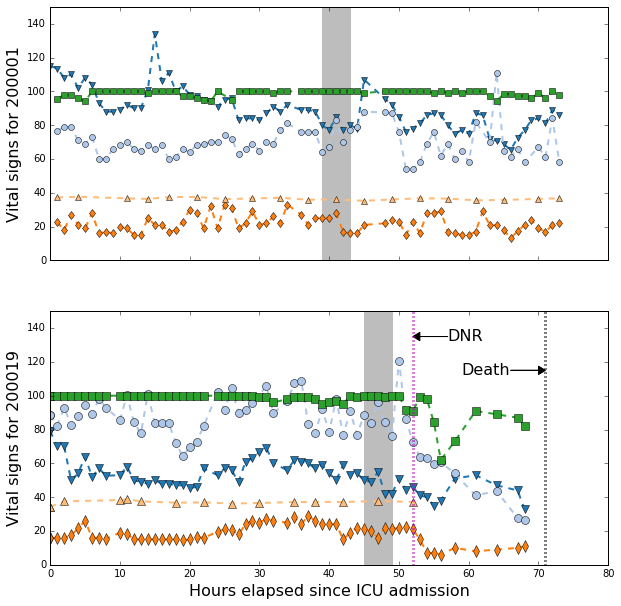

In [50]:
# generate a random time dictionary
T_WINDOW=4
df_tmp=df_offset.copy().merge(df_censor, how='left', left_on='icustay_id', right_on='icustay_id')
time_dict = mp.generate_times(df_tmp, T=2, seed=111, censor=True)


# define the patient
iid  = 200001
iid2 = 200019

df_pat = df.loc[df['icustay_id']==iid, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid, 'deathtime_hours'].values

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True, figsize=[10,10])

pretty_labels = {'heartrate': 'Heart rate',
                 'meanbp': 'Mean blood pressure',
                 'resprate': 'Respiratory rate',
                 'spo2': 'Peripheral oxygen saturation',
                 'tempc': 'Temperature',
                 'bg_ph': 'pH',
                 'bg_bicarbonate': 'Serum bicarbonate',
                 'hemoglobin': 'Hemoglobin',
                 'potassium': 'Potassium',
                 'inr': 'International normalized ratio',
                 'bg_lactate': 'Lactate',
                 'wbc': 'White blood cell count'}
#var_list = df.columns

# first plot all the vitals in subfigure 1
var_vitals = [u'heartrate', u'meanbp', u'resprate', u'tempc', u'spo2']

i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[0].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)],
                      color=tableau20[i], linewidth=2)
        i+=1
        

axarr[0].set_ylim([0,150])
y_lim = axarr[0].get_ylim()

# add ICU discharge
if dischtime is not np.nan:
    axarr[0].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)

# add a grey patch to represent the window
endtime = time_dict[iid]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[0].add_patch(rect)
# #axarr[0].text(starttime/60.0-4-2,4, 'window',fontsize=16)

axarr[0].set_ylabel('Vital signs for {}'.format(iid),fontsize=16)



# next plot the vitals for the next patient in subfigure 2
df_pat = df.loc[df['icustay_id']==iid2, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid2, 'deathtime_hours'].values


i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed since ICU admission'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[1].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)], markersize=8,
                      color=tableau20[i], linewidth=2)
        i+=1

axarr[1].set_ylim([0,150])
y_lim = axarr[1].get_ylim()

# add ICU discharge
if deathtime is not np.nan:
    axarr[1].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)
    axarr[1].arrow(deathtime-5, 115, 4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(deathtime-12, 112.5, 'Death', fontsize=16)
    
# add DNR
dnrtime = df_censor.loc[df_censor['icustay_id']==iid2, 'censortime_hours'].values
if dnrtime.shape[0]>0:
    axarr[1].plot([dnrtime,dnrtime], y_lim, 'm:', linewidth=3)
    axarr[1].arrow(dnrtime+5, 135, -4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(dnrtime+5, 132.5, 'DNR',fontsize=16)

# add a patch to represent the window
endtime = time_dict[iid2]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[1].add_patch(rect)




axarr[1].set_xlabel(t_unit,fontsize=16)
axarr[1].set_ylabel('Vital signs for {}'.format(iid2),fontsize=16)
#axarr[1].legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=3)
plt.show()

# Both 24 hours and 4 hour window

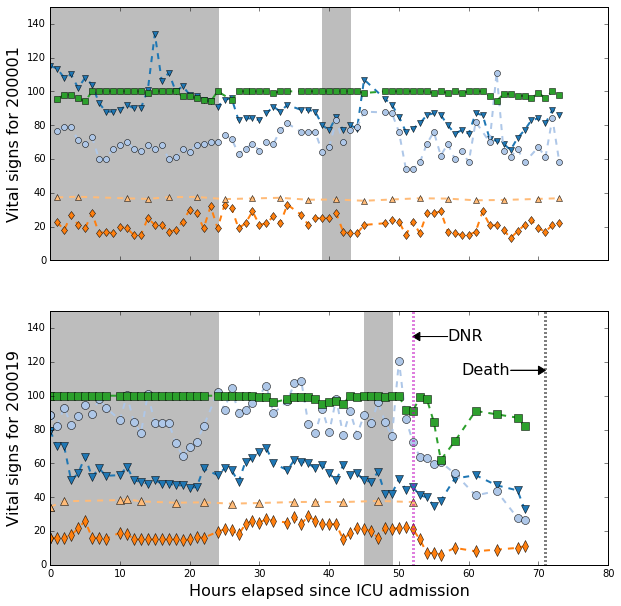

In [61]:
# generate a random time dictionary
T_WINDOW=4
df_tmp=df_offset.copy().merge(df_censor, how='left', left_on='icustay_id', right_on='icustay_id')
time_dict = mp.generate_times(df_tmp, T=2, seed=111, censor=True)


# define the patient
iid  = 200001
iid2 = 200019

df_pat = df.loc[df['icustay_id']==iid, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid, 'deathtime_hours'].values

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True, figsize=[10,10])

pretty_labels = {'heartrate': 'Heart rate',
                 'meanbp': 'Mean blood pressure',
                 'resprate': 'Respiratory rate',
                 'spo2': 'Peripheral oxygen saturation',
                 'tempc': 'Temperature',
                 'bg_ph': 'pH',
                 'bg_bicarbonate': 'Serum bicarbonate',
                 'hemoglobin': 'Hemoglobin',
                 'potassium': 'Potassium',
                 'inr': 'International normalized ratio',
                 'bg_lactate': 'Lactate',
                 'wbc': 'White blood cell count'}
#var_list = df.columns

# first plot all the vitals in subfigure 1
var_vitals = [u'heartrate', u'meanbp', u'resprate', u'tempc', u'spo2']

i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[0].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)],
                      color=tableau20[i], linewidth=2)
        i+=1
        

axarr[0].set_ylim([0,150])
y_lim = axarr[0].get_ylim()

# add ICU discharge
if dischtime is not np.nan:
    axarr[0].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)

# add a grey patch to represent the 4 hour window
endtime = time_dict[iid]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[0].add_patch(rect)
# #axarr[0].text(starttime/60.0-4-2,4, 'window',fontsize=16)


# add a grey patch to represent the 24 hour window
rect = matplotlib.patches.Rectangle( (0, y_lim[0]), 24, y_lim[1], color='#bdbdbd')
axarr[0].add_patch(rect)
# #axarr[0].text(starttime/60.0-4-2,4, 'window',fontsize=16)

axarr[0].set_ylabel('Vital signs for {}'.format(iid),fontsize=16)



# next plot the vitals for the next patient in subfigure 2
df_pat = df.loc[df['icustay_id']==iid2, :].set_index('hr')
deathtime = df_offset.loc[df_offset['icustay_id']==iid2, 'deathtime_hours'].values


i=0
t_scale = 1.0 # divide by this to get from hours to t_unit
t_unit = 'Hours elapsed since ICU admission'
for v in var_vitals:
    idx = ~df_pat[v].isnull()
    if np.sum(idx) > 0:
        axarr[1].plot(df_pat.loc[idx,v].index/t_scale, df_pat.loc[idx,v].values, '--',
                      label=pretty_labels[v],
                      marker=marker[np.mod(i,7)], markersize=8,
                      color=tableau20[i], linewidth=2)
        i+=1

axarr[1].set_ylim([0,150])
y_lim = axarr[1].get_ylim()

# add ICU discharge
if deathtime is not np.nan:
    axarr[1].plot([deathtime,deathtime], y_lim, 'k:',linewidth=3)
    axarr[1].arrow(deathtime-5, 115, 4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(deathtime-12, 112.5, 'Death', fontsize=16)
    
# add DNR
dnrtime = df_censor.loc[df_censor['icustay_id']==iid2, 'censortime_hours'].values
if dnrtime.shape[0]>0:
    axarr[1].plot([dnrtime,dnrtime], y_lim, 'm:', linewidth=3)
    axarr[1].arrow(dnrtime+5, 135, -4, 0, head_width=5, head_length=1, fc='k', ec='k')
    axarr[1].text(dnrtime+5, 132.5, 'DNR',fontsize=16)

# add a patch to represent the 4 hour window
endtime = time_dict[iid2]
rect = matplotlib.patches.Rectangle( (endtime-T_WINDOW, y_lim[0]), T_WINDOW, y_lim[1], color='#bdbdbd')
axarr[1].add_patch(rect)

axarr[1].arrow(dnrtime+5, 135, -4, 0, head_width=5, head_length=1, fc='k', ec='k')
axarr[1].text(dnrtime+5, 132.5, 'DNR',fontsize=16)

# add a patch to represent the 24 hour window
rect = matplotlib.patches.Rectangle( (0, y_lim[0]), 24, y_lim[1], color='#bdbdbd')
axarr[1].add_patch(rect)


axarr[1].arrow(dnrtime+5, 135, -4, 0, head_width=5, head_length=1, fc='k', ec='k')
axarr[1].text(dnrtime+5, 132.5, 'DNR',fontsize=16)

axarr[1].set_xlabel(t_unit,fontsize=16)
axarr[1].set_ylabel('Vital signs for {}'.format(iid2),fontsize=16)
#axarr[1].legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=3)
plt.show()